In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

# Homework 3:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [2]:
!pwd


/home/afrah/ai-science-training-series/03_advanced_neural_networks


In [3]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    root="/home/afrah/ai-science-training-series/datasets/CIFAR-10/",
    train=True,
    download=False,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    root="/home/afrah/ai-science-training-series/datasets/CIFAR-10/",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [5]:
from tqdm.notebook import tqdm

def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss


def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()


In [24]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2 ,kernel_size =2 , padding =1):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])
        self.kernel_size = kernel_size
        self.padding = padding
        layers=[
            nn.Conv2d(in_channels,out_channels,kernel_size = kernel_size,stride =stride),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            # nn.Conv2d(in_channels,out_channels,kernel_size = stride,stride =stride ,padding = padding),
            # nn.BatchNorm2d(out_channels),
            # nn.GELU(),
            # nn.MaxPool2d(3)
        ]
        
        self.downsample=nn.Sequential(*layers)

        # self.downsample = nn.Conv2d(
        #     in_channels=in_channels, 
        #     out_channels=out_channels,
        #     kernel_size = stride,
        #     stride = stride,
        # )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[4,4],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )
        self.conv4 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )
        self.dropout = nn.Dropout(p=0.2) 

    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)
        x = torch.nn.functional.gelu(x)

        x = self.conv4(x)
        x = torch.nn.functional.gelu(x)

        x = self.dropout(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce batches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Dropout(p=0.2),
            nn.Linear(current_n_filters ,current_n_filters ),
            nn.Dropout(p=0.2),
            nn.Linear(current_n_filters, 10)

        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [25]:

model = Classifier(64, 4, 2)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         1,088
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         4,160
│    │    └─Dropout: 3-6                 [128, 64, 32, 32]         --
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-7                  [128, 64, 32, 32]  

In [26]:


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

epochs = 40
train_loss_history = []
train_accuracy_history = []
validation_loss_history = []
validation_accuracy_hisstory = []
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
        train_loss_history.append(loss)
        train_accuracy_history.append(acc)

        print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        validation_loss_history.append(loss_val)
        validation_accuracy_hisstory.append(acc_val)

        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.221, accuracy: 55.933


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.240, accuracy: 55.301


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: training loss: 0.959, accuracy: 65.997


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 0.993, accuracy: 64.330


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: training loss: 0.804, accuracy: 72.497


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.859, accuracy: 69.858


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: training loss: 0.597, accuracy: 79.138


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.674, accuracy: 75.959


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: training loss: 0.597, accuracy: 79.106


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.698, accuracy: 75.633


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.471, accuracy: 83.297


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.568, accuracy: 79.638


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: training loss: 0.443, accuracy: 84.330


Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.562, accuracy: 79.638


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: training loss: 0.436, accuracy: 84.387


Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.585, accuracy: 79.302


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: training loss: 0.425, accuracy: 85.466


Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 0.596, accuracy: 79.717


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: training loss: 0.356, accuracy: 87.168


Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.538, accuracy: 80.845


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.315, accuracy: 88.995


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.500, accuracy: 82.654


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: training loss: 0.282, accuracy: 90.091


Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.467, accuracy: 83.347


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: training loss: 0.287, accuracy: 89.884


Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.495, accuracy: 83.129


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: training loss: 0.259, accuracy: 90.860


Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 0.484, accuracy: 83.594


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: training loss: 0.245, accuracy: 91.219


Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.479, accuracy: 83.910


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.236, accuracy: 91.673


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.472, accuracy: 83.406


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: training loss: 0.287, accuracy: 89.592


Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.569, accuracy: 82.150


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: training loss: 0.296, accuracy: 89.746


Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.545, accuracy: 82.674


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: training loss: 0.231, accuracy: 92.013


Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.522, accuracy: 83.534


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: training loss: 0.205, accuracy: 92.672


Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.487, accuracy: 84.217


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.195, accuracy: 93.248


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.463, accuracy: 84.533


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: training loss: 0.206, accuracy: 92.527


Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.500, accuracy: 83.930


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: training loss: 0.208, accuracy: 92.385


Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.502, accuracy: 83.970


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: training loss: 0.213, accuracy: 92.297


Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.485, accuracy: 82.921


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: training loss: 0.236, accuracy: 92.105


Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.562, accuracy: 83.396


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.210, accuracy: 92.674


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.524, accuracy: 83.851


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: training loss: 0.206, accuracy: 92.722


Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.554, accuracy: 83.792


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: training loss: 0.151, accuracy: 94.651


Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.484, accuracy: 85.295


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: training loss: 0.135, accuracy: 95.110


Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.457, accuracy: 85.186


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: training loss: 0.179, accuracy: 93.528


Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.518, accuracy: 83.881


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 0.172, accuracy: 94.005


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 0.500, accuracy: 84.474


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31: training loss: 0.183, accuracy: 93.413


Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 0.499, accuracy: 83.999


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32: training loss: 0.166, accuracy: 94.074


Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 0.498, accuracy: 84.118


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33: training loss: 0.169, accuracy: 93.967


Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 0.507, accuracy: 84.662


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34: training loss: 0.227, accuracy: 91.968


Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 0.632, accuracy: 82.100


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 0.245, accuracy: 91.591


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 0.625, accuracy: 82.110


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36: training loss: 0.148, accuracy: 94.639


Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 0.515, accuracy: 84.612


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37: training loss: 0.166, accuracy: 93.950


Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 0.519, accuracy: 84.484


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38: training loss: 0.132, accuracy: 95.245


Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 0.480, accuracy: 85.235


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39: training loss: 0.213, accuracy: 92.490


Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 0.594, accuracy: 83.010


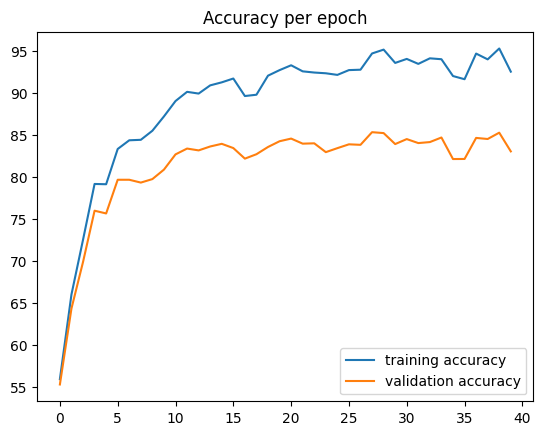

In [27]:
plt.plot(train_accuracy_history, label='training accuracy')
plt.plot(validation_accuracy_hisstory, label= 'validation accuracy')
plt.title('Accuracy per epoch')
plt.legend();

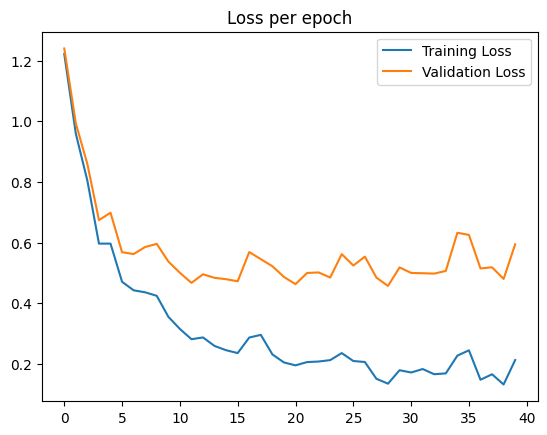

In [28]:
plt.plot(train_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label= 'Validation Loss')
plt.title('Loss per epoch')
plt.legend();

A better validation accuracy can be achieved by changing the following parameters:

- Increase number of trainable parameters by adding more convolution layers in `ConvNextBlock` and morre linear and drop out layers in the `Sequential` block.
- Lower the value of kernel size from 7 to 4 to better capture the smaller details.
- Add DropOut layers between the dense layers.
- Increase weight decay parameter to $10\%$ to reduce overfitting.
- Increase number of epochs.